<a href="https://colab.research.google.com/github/Susena-V/DataSci-ML-DL-AI/blob/main/Spectral_Clustering_Data_Science.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spectral Clustering

An amazing graph partitioning algorithm which can be adapted to other data in order to classify them.

Uses EigenVectors.

Over here we will first see an example on a classic graph - The Karate Club Graph

Then we will apply it on some synthetic data then some real data.

In [333]:
import numpy as np #For the math and vector operations
import matplotlib.pyplot as plt #You gotta see what you are doing
import networkx as nx #Use a graph dataset
from sklearn.cluster import KMeans # Kmeans when we want mulitple classes
from sklearn.datasets import make_moons
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import SpectralClustering


The Classic algorithm splits data in just two categories, but by projecting the points onto the space of eigenvectors 2,3 and 4 and applying clustering on these points.

### Steps:

1. Find the Laplacian matrix - this is the Degree Matrix of the graph minus the Adjacency matrix of the Graph
2. Find the eigenvalues and eigenvectors of the Laplacian Matrix.
3. Find the second smallest eigenvalue and the eigenvector corresponding to it will give you the optimal separation of the graph. We split nodes based on the sign of the eigenvector.


### Multiclass:
For now we have partitioned the graph into two components/ classified our data in two classes. So in order to classify in multiple dimensions - we take eigenvectors 2,3 and 4 and create a vector space from them. We then project the points from our Laplacian into this space and then apply K-Means on the points in this space to obtain the classification.

In [378]:
# Create an adjacency matrix when given an adjacency list
def make_adj_mat(adj_list):
    n = len(adj_list)
    adj_mat = np.zeros((n,n), dtype = int)
    degree_mat = np.zeros((n,n), dtype = int)
    for key, val in adj_list.items():
        for value in val:
            adj_mat[key][value] = 1
        degree_mat[key][key] = len(val)


    return adj_mat, degree_mat

def get_laplacian(adj_list):

  A,D = make_adj_mat(adj_list)
  L = D-A

  return L

def find_eigenvals_eigenvectors(L):
  eigval, eigvectors = np.linalg.eigh(L)

  e2 = eigvectors[:, 1] # get 2nd eigenvector
  e3 = eigvectors[:, 2]
  e4 = eigvectors[:, 3]

  return np.array(e2), np.array(e3), np.array(e4)


## Karate Club

Text(0.5, 1.0, "Zachary's Karate Club")

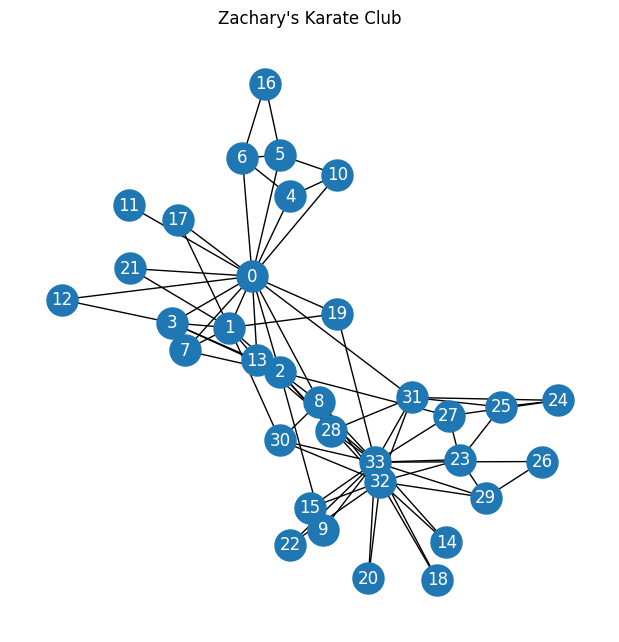

In [335]:
# Load the classic karate club graph
G = nx.karate_club_graph()
pos = nx.spring_layout(G, seed=42)


adj_list = nx.to_dict_of_lists(G)

plt.figure(figsize = (6,6))
nx.draw(G, pos, with_labels = True, node_size = 500, font_color = "white")
plt.title("Zachary's Karate Club")

In [336]:
L = get_laplacian(adj_list) # Get Laplacian
e2, _, _ = find_eigenvals_eigenvectors(L) # Find the eigenvectors

#Obtain the partitions
partitions = {
    0: np.where(e2<0)[0].tolist(),
    1: np.where(e2 >= 0 )[0].tolist()
}

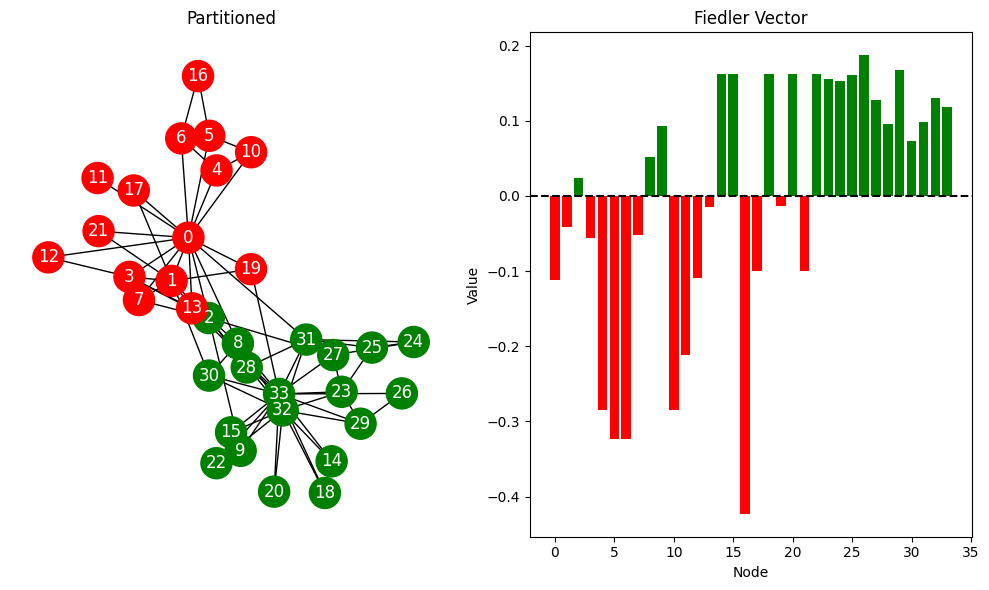

In [337]:
colors = ["red" if node in partitions[0] else "green" for node in G.nodes()]

plt.figure(figsize = (10,6))

plt.subplot(1,2,1)
plt.title("Partitioned")
nx.draw(G, pos, node_color = colors, with_labels = True, node_size = 500, font_color = "white")

plt.subplot(1,2,2)
plt.bar(range(len(e2)), e2, color = ["red" if val<0 else "green" for val in e2])
plt.axhline(0, color='black', linestyle='--')
plt.title("Fiedler Vector")
plt.xlabel("Node")
plt.ylabel("Value")


plt.tight_layout()
plt.show()

## Make Moons

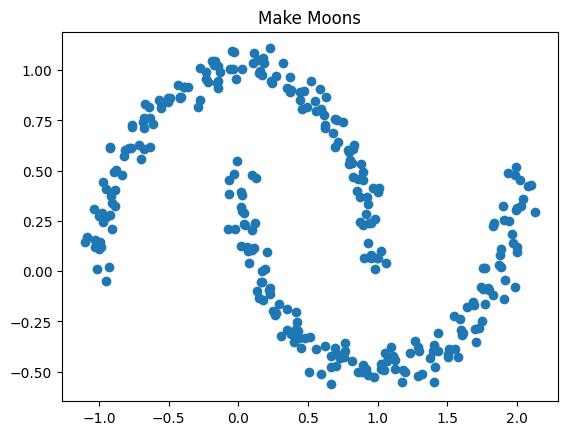

In [338]:
X, y = make_moons(n_samples=300, noise=0.05, random_state=42)

# y gives us the labels, we compare against our spectral clustering

plt.scatter(X[:,0], X[:, 1])
plt.title("Make Moons")
plt.show()

### Make graph

Create a weighted fully connected graph using gaussian connectivity


In [382]:
def gaussian_affinity(X, sigma = 0.1):
  n = len(X)
  A = np.zeros((n,n))
  for i in range(n):
    for j in range(i+1, n):
      diff = X[i] - X[j]
      w = np.exp(-np.dot(diff, diff)/(2*sigma**2))
      A[i,j] = w
      A[j,i] = w

    np.fill_diagonal(A,0)
  return A

In [386]:
#create a fully connected graph
A = gaussian_affinity(X, 0.2)
D = np.diag(A.sum(axis=1))

D_inv_sqrt = np.diag(1 / np.sqrt(A.sum(axis=1)))

L = D - A # unnormalited
L_sym = np.eye(len(A)) - D_inv_sqrt @ A @ D_inv_sqrt #Symmetric Normalized
L_rw = np.eye(len(A)) - np.linalg.inv(D) @ A # Random walk normalized

In [384]:

def partition_from_laplacian(L):
  e2, _, _ = find_eigenvals_eigenvectors(L) # Find the eigenvectors

  #Obtain the partitions
  partitions = {
      0: np.where(e2<0)[0].tolist(),
      1: np.where(e2 >= 0 )[0].tolist()
  }

  labels = (e2<0).astype(int)

  colors = ["red" if node in partitions[0] else "green" for node in G.nodes()]

  plt.figure(figsize=(15,5))

  plt.subplot(1,3,1)
  plt.scatter(X[:,0], X[:, 1], c=labels, cmap="rainbow")
  plt.title("Make Moons Predicted")

  plt.subplot(1,3,2)
  plt.title("Partitioned")
  nx.draw(G, pos, node_color = colors, with_labels = True, node_size = 500, font_color = "white")

  plt.subplot(1,3,3)
  plt.scatter(X[:,0], X[:, 1], c=y, cmap="viridis")
  plt.title("Make Moons Actual cluster")


  plt.tight_layout()
  plt.show()

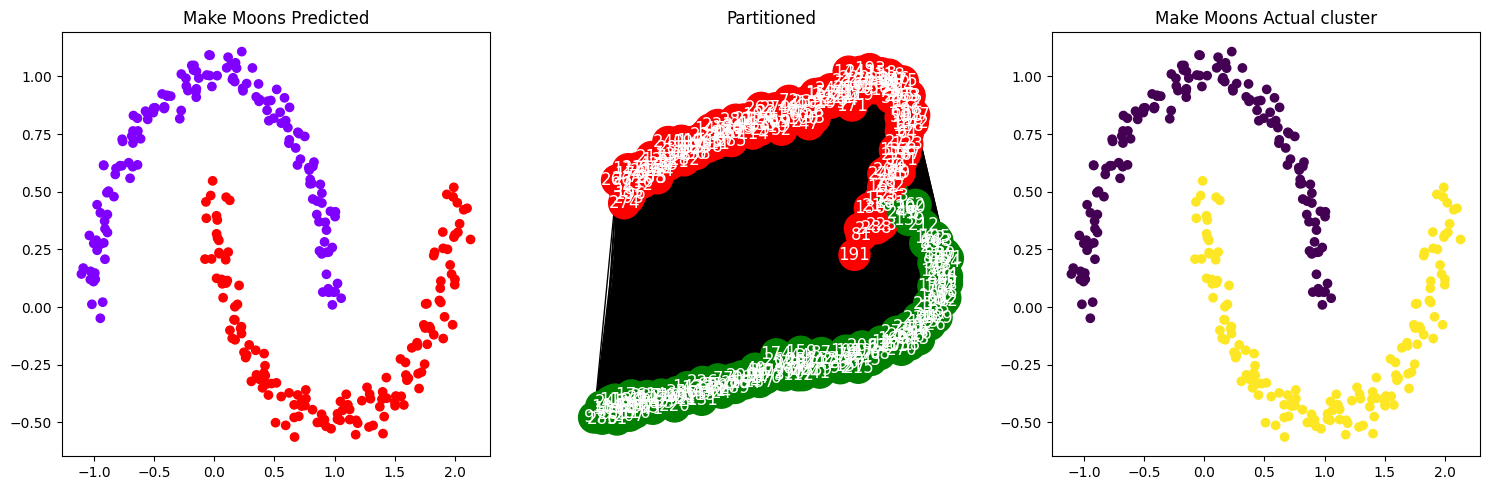

In [381]:
partition_from_laplacian(L)

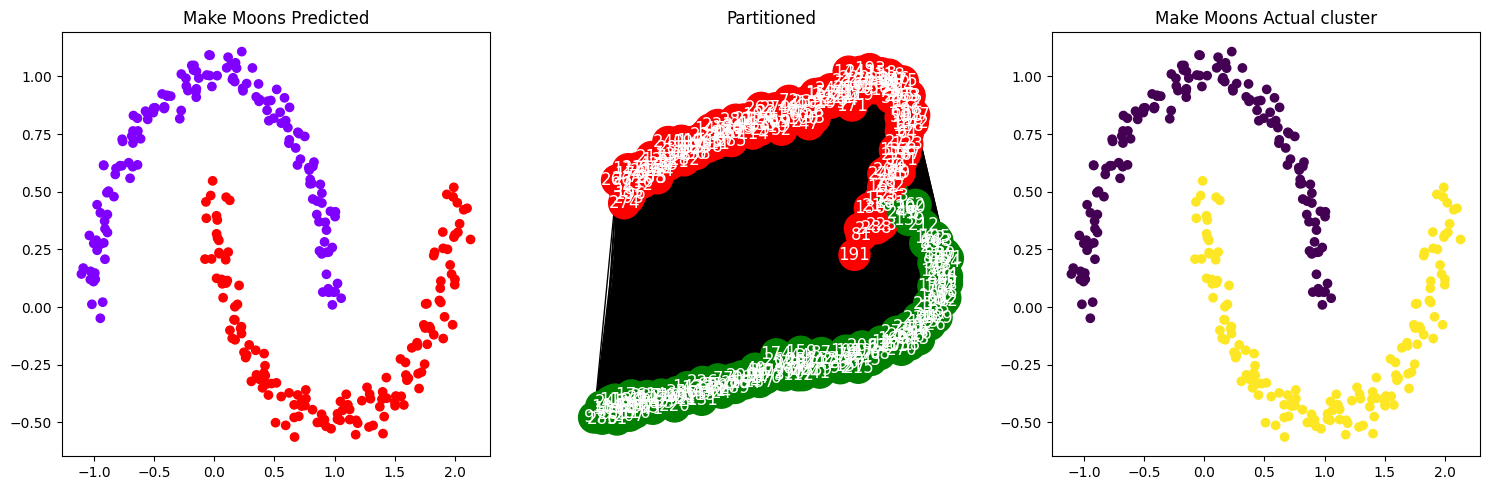

In [388]:
partition_from_laplacian(L_sym)

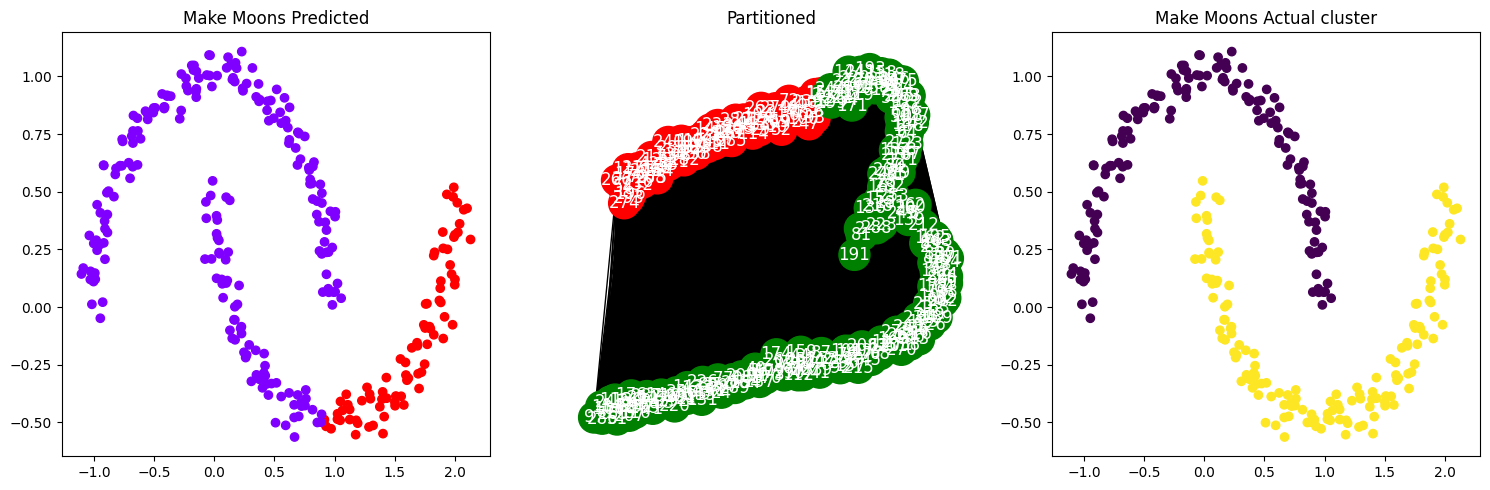

In [387]:
partition_from_laplacian(L_rw)

## Sklearn's spectral clustering




/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


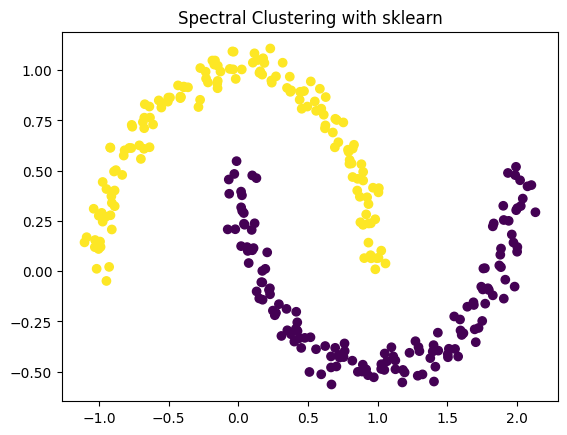

In [349]:

sc = SpectralClustering(
    n_clusters=2,          # number of clusters
    affinity='nearest_neighbors',  # build a kNN graph internally
    n_neighbors=10,        # k in kNN
    random_state=42
)
labels = sc.fit_predict(X)  # computes Laplacian, eigenvectors, k-means automatically

plt.scatter(X[:,0], X[:,1], c=labels, cmap='viridis')
plt.title("Spectral Clustering with sklearn")
plt.show()


## Things Tried

In [339]:
def euclidean(PX, PY):
  return np.linalg.norm(PX-PY)

In [340]:
lenX = len(X)

distances = np.zeros((len(X), len(X)))

for i in range(lenX):
    for j in range(i+1, lenX):
        d = euclidean(X[i], X[j])
        distances[i, j] = d
        distances[j, i] = d

k = 7 # 7 nearest neighnors
A = np.zeros((len(X), len(X)))

#connect to the 7 nearest neighbours

for i in range(lenX):
    # Get indices of k smallest distances (nearest neighbors)
    neighbors_idx = np.argpartition(distances[i], k)[:k]  # k nearest
    A[i, neighbors_idx] = 1 # connect to the neighbour
A = np.maximum(A, A.T)
np.fill_diagonal(A, 0)
D = np.diag(np.sum(A, axis = 1))

L = D-A